<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%84%9C%EC%9A%B8%EB%9E%9C%EB%93%9C%EB%A7%88%ED%81%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울 랜드마크 이미지 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import os
import gc

from tqdm import tqdm, tqdm_notebook
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data/dataset.zip'

In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류


- 데이터 불러오기

In [6]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

- 하이퍼파라미터

In [104]:
SAVE_PATH = './weight'
MODEL_NAME = 'convmixer'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
NUM_CLASSES = 10
N_FOLD = 5
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 5e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
IMAGE_H = 240
IMAGE_W = 240
SEED = 2022

- 가중치 저장폴더

In [105]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [106]:
create_folder(SAVE_PATH)

- 이미지 불러오기

In [107]:
def load_images(path):
    images = []
    for img_path in tqdm_notebook(sorted(glob(path + '/*.PNG'))): ## path에 들어있는 PNG 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = cv2.imread(img_path)  
        an_img = cv2.cvtColor(an_img, cv2.COLOR_BGR2RGB)
        an_img = cv2.resize(an_img, dsize=(IMAGE_W, IMAGE_H), interpolation=cv2.INTER_LINEAR) 
        images.append(an_img)  
    
    images = np.array(images).astype(np.float32)
    return images

In [108]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

  0%|          | 0/723 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [109]:
train_images.shape, test_images.shape

((723, 240, 240, 3), (199, 240, 240, 3))

## 시각화

- 이미지

In [17]:
def show_images(images, labels, nrows=3, ncols=3) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    nums = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for i, ax in enumerate(axs.flatten()):
        num = nums[i]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[num])
        ax.imshow(images[num])
    fig.tight_layout()

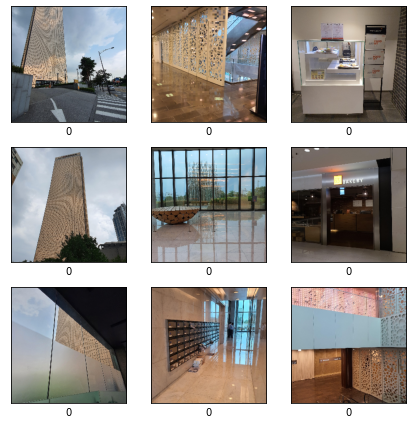

In [18]:
show_images(train_images[df.query('label == 0').index].astype(np.uint8), [0]*1000)

`-` 클래스 0은 외부에서 찍은 사진과 내부에서 찍은 사진으로 나뉜다

`-` 외부에서 찍은 사진은 비교적 일관적이지만 내부에서 찍은 사진은 제각각이다

`-` 적절한 라벨스무딩이 필요할 듯 하다

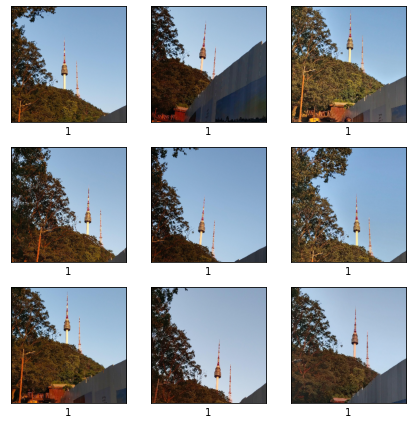

In [19]:
show_images(train_images[df.query('label == 1').index].astype(np.uint8), [1]*1000) 

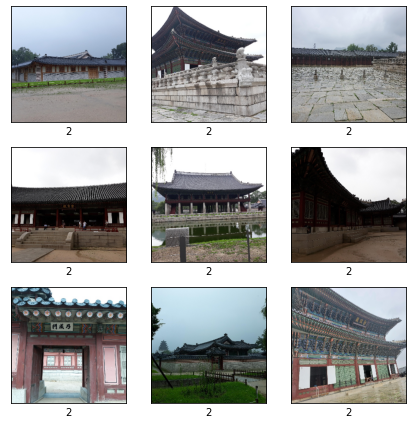

In [20]:
show_images(train_images[df.query('label == 2').index].astype(np.uint8), [2]*1000)

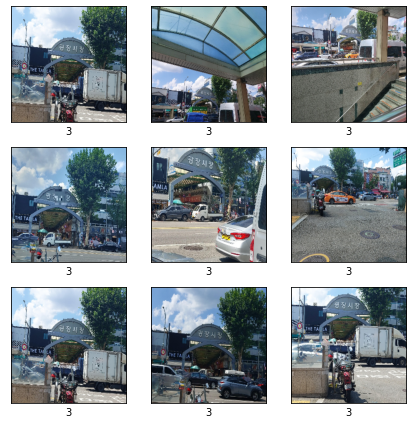

In [21]:
show_images(train_images[df.query('label == 3').index].astype(np.uint8), [3]*1000)

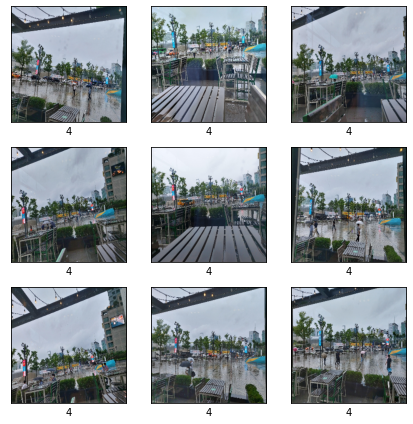

In [22]:
show_images(train_images[df.query('label == 4').index].astype(np.uint8), [4]*1000)

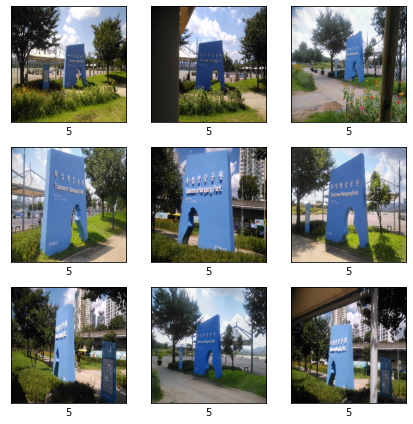

In [23]:
show_images(train_images[df.query('label == 5').index].astype(np.uint8), [5]*1000)

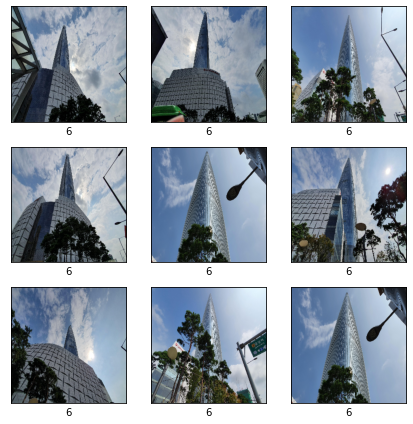

In [24]:
show_images(train_images[df.query('label == 6').index].astype(np.uint8), [6]*1000)

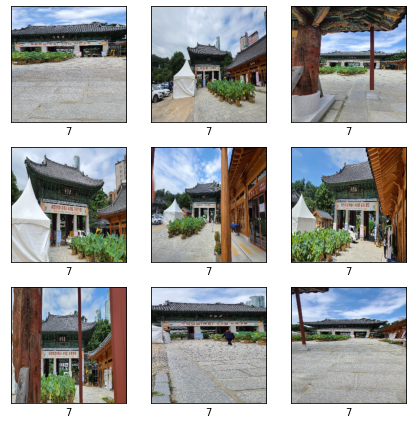

In [25]:
show_images(train_images[df.query('label == 7').index].astype(np.uint8), [7]*1000)

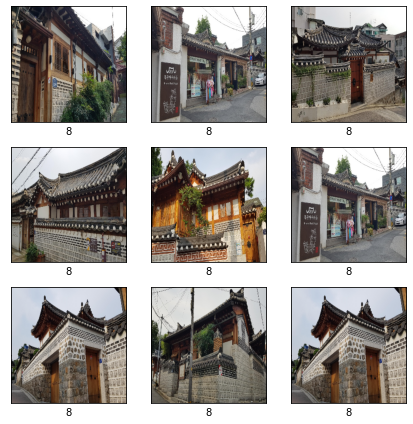

In [110]:
show_images(train_images[df.query('label == 8').index].astype(np.uint8), [8]*1000)

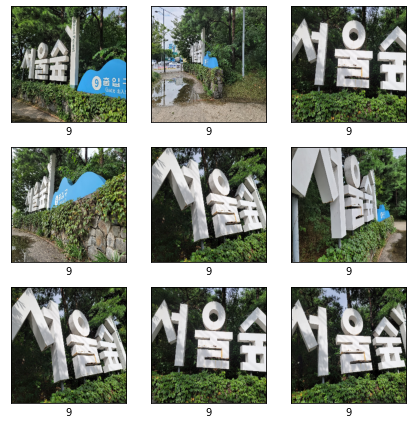

In [27]:
show_images(train_images[df.query('label == 9').index].astype(np.uint8), [9]*1000)

- 라벨

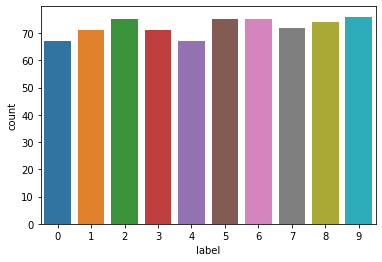

In [28]:
sns.countplot(data=df, x='label')

`-` 라벨별 개수는 비슷하다

## 모델 학습 준비

In [29]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [32]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [33]:
def seed_everything(seed=22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [34]:
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

- 데이터 셋과 데이터 로더

In [113]:
class CustomDataset(Dataset):
  
    def __init__(self, images, labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)  

In [114]:
def get_dataloader(X, y=None, transforms=None, shuffle_dataloader=True):
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

In [111]:
RGB_MEAN = [np.mean((train_images[..., i])) / 255 for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) / 255 for i in range(3)]  

In [112]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(train_mode=True):
    transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
        ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.CenterCrop(224, 224),   
            A.Perspective(scale=0.15, p=0.5),
            A.Rotate(limit=25, p=0.5),  
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
            ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])

    return transforms  ## 데이터 변환 방식을 반환

`-` 색을 바꾸면 클래스 0과 6을 구분하기 힘들다

`-` 그래서 색을 변형시키는 변환은 사용하지 않겠다

In [39]:
target = df['label'].values

- 딥러닝 모델

In [40]:
## Copyright (c) 2021 Author(s) of ICLR 2022 Submission "Patches Are All You Need?"
## 코드: https://github.com/locuslab/convmixer/blob/main/convmixer.py
class Residual(nn.Module):
  
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding='same'),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

- 가중치 초기화

In [41]:
## layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(2 / y))
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

- 조기 중단

In [115]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):
        score = -val_loss  ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            if self.counter >= self.patience:  ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0  ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.n_fold}.pt') 
        self.val_loss_min = val_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc  ## 이때의 valid accuracy도 변경해준다

    def update_fold(self):
        self.n_fold += 1

    def reset_score(self):
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0

## 모델 K겹 교차검증

In [43]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [116]:
skfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [117]:
early_stopping = EarlyStopping(patience=20,
                               verbose=False,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               n_fold=1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

- 모델 교차검증 관련 함수

In [118]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 에폭 하나당 배치들의 평균 훈련 오차를 반환"""  
    train_avg_loss = 0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        yhat = model(X)
        loss = loss_fn(yhat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_avg_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [119]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 에폭 하나당 배치들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y)  
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader)    

    return valid_avg_loss, valid_avg_acc

In [120]:
def show_loss_plot(train_loss, valid_loss, ax) -> None:
    assert len(train_loss) == len(valid_loss)
    
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [121]:
def kfold_cross_validate(model, X, y, skfold, loss_fn, early_stopping):
    seed_everything(SEED)  ## 정확한 loss 재현을 위함
    model_avg_acc = []  ## fold 마다 valid셋의 평균 정확도
    model_avg_loss = []  ## fold 마다 valid셋의 평균 손실
    model_epoch_train_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 train의 한 epoch당 valid의 배치 평균 손실
    model_epoch_valid_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 valid의 한 epoch당 valid의 배치 평균 손실

    for i, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{i + 1} / {N_FOLD}] Fold Training......')

        ## 메모리 절약
        clear_gpu()
        
        ## 학습 데이터와 평가 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]
        y_train = torch.tensor(y_train, dtype=torch.int64)   
        y_valid = torch.tensor(y_valid, dtype=torch.int64)   

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms(train_mode=True))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms(train_mode=False))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device)) 

        ## optimizer, scheduler
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) 
        scheduler = None

        ## early stop, score 관련 파라미터 초기화
        early_stopping.reset_score()
        
        ## fold 마다 모델 학습
        for epoch in tqdm_notebook(range(1, EPOCHS + 1)): ## (배치사이즈 * 에폭) 만큼 훈련시킴           
            model, train_avg_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_avg_loss, valid_avg_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            model_epoch_train_loss[i].append(train_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
            model_epoch_valid_loss[i].append(valid_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_infomation = f'[Epoch: {epoch:>3}] train loss = {train_avg_loss:>.5f}  valid loss = {valid_avg_loss:>.5f}  valid acc = {valid_avg_acc:>.5f}'

            if print_score_condition: 
                ## 평균 배치 훈련 오차와 평가 오차 출력
                print(score_infomation) 
                
            ## epoch 마다 early stopping 실행
            early_stopping(model, valid_avg_loss, valid_avg_acc)  ## __call__ function
            if early_stopping.early_stop:  ## early_stop이 true이면
                if not print_score_condition:
                    ## 이미 출력한 epoch에 대해 중복으로 출력하지 않기 위함
                    print(score_infomation) 
                print('Early Stopping!')
                break 

        model_avg_acc.append(early_stopping.val_acc)  ## fold 마다 loss가 가장 작은 모델의 정확도
        model_avg_loss.append(early_stopping.val_loss_min)  ## fold 마다 loss가 가장 작은 모델의 손실
        
        ## fold 마다 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
        print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.5f}  Valid Accuracy: {early_stopping.val_acc:.5f}', end='\n\n')

        ## early stop, 다음 fold 학습
        early_stopping.update_fold() 
        
    ## 마지막으로 fold 마다 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
    print(f'{N_FOLD} Fold Mean Valid Accuracy: {np.mean(model_avg_acc):.5f}')
    print(f'{N_FOLD} Fold Mean Valid Loss: {np.mean(model_avg_loss):.5f}')

    return model, model_epoch_train_loss, model_epoch_valid_loss, model_avg_acc, model_avg_loss

- 모델 선언 및 초기화시킨 가중치 저장

In [122]:
seed_everything(SEED)
model = ConvMixer(dim=2**7, depth=8, kernel_size=7, patch_size=7, n_classes=NUM_CLASSES)
model.apply(init_weights)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

- 모델 K겹 교차검증

In [123]:
model, model_epoch_train_loss, model_epoch_valid_loss, _, _ = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.33761  valid loss = 1.35099  valid acc = 0.53103
[Epoch:  10] train loss = 0.40445  valid loss = 0.59381  valid acc = 0.96552
[Epoch:  20] train loss = 0.36224  valid loss = 0.38458  valid acc = 0.99310
[Epoch:  30] train loss = 0.38542  valid loss = 0.36599  valid acc = 0.98621
[Epoch:  40] train loss = 0.34519  valid loss = 0.34472  valid acc = 0.99310
[Epoch:  50] train loss = 0.34495  valid loss = 0.36546  valid acc = 0.97931
[Epoch:  60] train loss = 0.38663  valid loss = 0.35736  valid acc = 0.99310
[Epoch:  70] train loss = 0.34932  valid loss = 0.35434  valid acc = 0.98621
[Epoch:  80] train loss = 0.33063  valid loss = 0.33414  valid acc = 0.99310
[Epoch:  90] train loss = 0.32285  valid loss = 0.34487  valid acc = 0.99310
[Epoch:  94] train loss = 0.31231  valid loss = 0.33561  valid acc = 0.98621
Early Stopping!
1 Fold -> Best Valid Loss: 0.32981  Valid Accuracy: 0.99310

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.28216  valid loss = 1.27649  valid acc = 0.63448
[Epoch:  10] train loss = 0.41627  valid loss = 0.39716  valid acc = 0.98621
[Epoch:  20] train loss = 0.38771  valid loss = 0.37855  valid acc = 0.98621
[Epoch:  30] train loss = 0.35453  valid loss = 0.35095  valid acc = 0.99310
[Epoch:  40] train loss = 0.34120  valid loss = 0.34360  valid acc = 0.98621
[Epoch:  50] train loss = 0.33239  valid loss = 0.36636  valid acc = 0.97931
[Epoch:  59] train loss = 0.33700  valid loss = 0.35970  valid acc = 0.97931
Early Stopping!
2 Fold -> Best Valid Loss: 0.33384  Valid Accuracy: 0.99310

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.31272  valid loss = 1.16659  valid acc = 0.62759
[Epoch:  10] train loss = 0.42107  valid loss = 0.40984  valid acc = 0.96552
[Epoch:  20] train loss = 0.38197  valid loss = 0.45301  valid acc = 0.95172
[Epoch:  30] train loss = 0.35533  valid loss = 0.37395  valid acc = 0.97931
[Epoch:  40] train loss = 0.33143  valid loss = 0.37760  valid acc = 0.97241
[Epoch:  50] train loss = 0.32980  valid loss = 0.35801  valid acc = 0.98621
[Epoch:  60] train loss = 0.32424  valid loss = 0.35629  valid acc = 0.97241
[Epoch:  67] train loss = 0.36994  valid loss = 0.34564  valid acc = 0.99310
Early Stopping!
3 Fold -> Best Valid Loss: 0.34012  Valid Accuracy: 0.98621

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.33006  valid loss = 1.21879  valid acc = 0.57639
[Epoch:  10] train loss = 0.38656  valid loss = 0.52256  valid acc = 0.95833
[Epoch:  20] train loss = 0.35256  valid loss = 0.43700  valid acc = 0.95833
[Epoch:  30] train loss = 0.33652  valid loss = 0.40648  valid acc = 0.96528
[Epoch:  40] train loss = 0.33336  valid loss = 0.39199  valid acc = 0.97222
[Epoch:  50] train loss = 0.30880  valid loss = 0.36841  valid acc = 0.97917
[Epoch:  60] train loss = 0.31784  valid loss = 0.36672  valid acc = 0.97917
[Epoch:  70] train loss = 0.31463  valid loss = 0.37800  valid acc = 0.97222
[Epoch:  80] train loss = 0.31099  valid loss = 0.38473  valid acc = 0.97222
[Epoch:  90] train loss = 0.32911  valid loss = 0.36371  valid acc = 0.97917
[Epoch: 100] train loss = 0.31461  valid loss = 0.36078  valid acc = 0.97917
4 Fold -> Best Valid Loss: 0.35174  Valid Accuracy: 0.97222

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.33702  valid loss = 1.08829  valid acc = 0.63194
[Epoch:  10] train loss = 0.39421  valid loss = 0.39623  valid acc = 0.97222
[Epoch:  20] train loss = 0.35510  valid loss = 0.36424  valid acc = 0.99306
[Epoch:  30] train loss = 0.35154  valid loss = 0.33846  valid acc = 0.99306
[Epoch:  40] train loss = 0.34233  valid loss = 0.39984  valid acc = 0.96528
[Epoch:  50] train loss = 0.31607  valid loss = 0.33846  valid acc = 0.99306
[Epoch:  60] train loss = 0.33823  valid loss = 0.32745  valid acc = 0.99306
[Epoch:  70] train loss = 0.32385  valid loss = 0.32140  valid acc = 0.99306
[Epoch:  80] train loss = 0.32373  valid loss = 0.34342  valid acc = 0.99306
[Epoch:  90] train loss = 0.31212  valid loss = 0.30946  valid acc = 1.00000
[Epoch: 100] train loss = 0.31721  valid loss = 0.32480  valid acc = 0.99306
5 Fold -> Best Valid Loss: 0.30946  Valid Accuracy: 1.00000

5 Fold Mean Valid Accuracy: 0.98893
5 Fold Mean Valid Loss: 0.33299


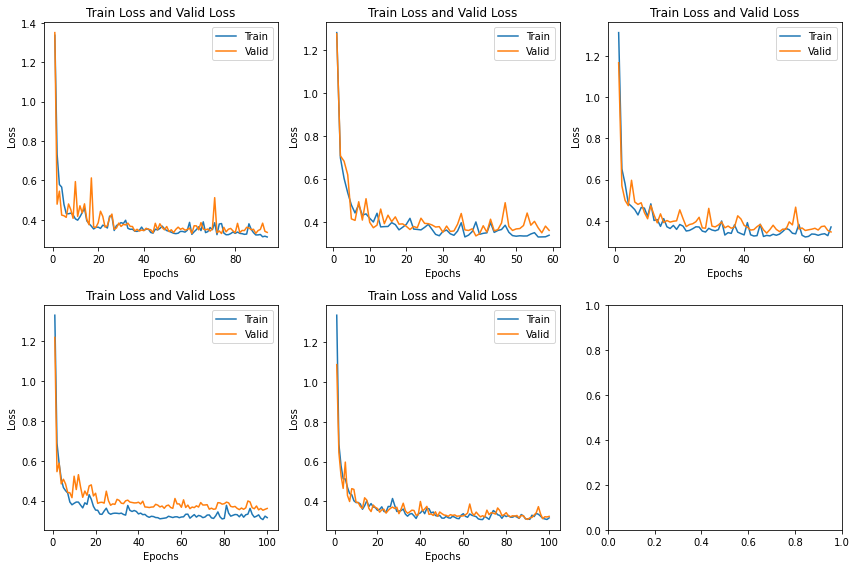

In [124]:
## fold 마다 epoch에 따른 train loss와 valid loss의 변화를 시각화
fig ,axs = plt.subplots(2, 3, figsize=(12, 8)) 
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(model_epoch_train_loss[i], model_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

## Test 예측

In [125]:
def predict(model, dataloader, weight_save_path, return_prob=False):
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환 """
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight in tqdm_notebook(weight_path_list):
        if MODEL_NAME not in weight:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device)
                yhat = model(X).cpu().numpy()

                if probs is None:
                    probs = yhat
                else:
                    probs = np.concatenate([probs, yhat])

        test_probs += (probs / N_FOLD) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률값
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1)  ## 최대값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률값
    return test_preds  ## 라벨값

In [126]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms(train_mode=False), shuffle_dataloader=False)

In [131]:
test_preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [132]:
submission['label'] = test_preds
submission.head()

,file_name,label
0,001.PNG,7
1,002.PNG,1
2,003.PNG,9
3,004.PNG,7
4,005.PNG,6


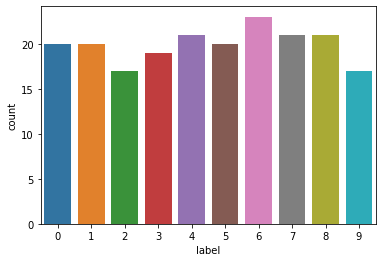

In [133]:
sns.countplot(data=submission, x='label')

In [134]:
# submission.to_csv(f'./Data/submission-{MODEL_NAME}9.csv', index=False)